<a href="https://colab.research.google.com/github/Beatriz-Yun/AIFFEL_LMS/blob/main/Fundamental/%5BF-24%5DLikelihood(MLE%EC%99%80MAP).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

데이터셋의 크기는 유한하기 때문에 데이터가 따르는 정확한 확률 분포를 구하는 것은 불가능하다. 그래서 파라미터(parameter, 매개 변수)에 의해 결정되는 머신러닝 모델을 만든 다음, 파라미터의 값을 조절함으로써 데이터의 분포를 간접적으로 표현한다.

<br>

모델이 표현하는 **확률 분포를 데이터의 실제 분포에 가깝게** 만드는 **최적의 파라미터 값**을 찾는 것이 **머신러닝의 목표**이다.

<br>

[참고](https://mml-book.github.io/)

# 목차
- 들어가며: 머신러닝의 목표
- 확률 변수로서의 모델 파라미터
- posterior와 prior, likelihood 사이의 관계
- likelihood와 머신러닝
- likelihood 감 잡기
- MLE: 최대 가능도 추론
- MLE 최적해 구하기
- MAP: 최대 사후 확률 추정
- MLE와 MAP의 비교

# 확률변수로서의 모델 파라미터

 파라미터 공간에서 두 점 $a, b$를 뽑아 $y=ax+b$의 그래프를 그리는 코드입니다. 이론상으로는 실수 집합 전체에서 샘플링을 해야 하지만 코드로 구현하기가 불가능하고, 간단한 시각화를 위해 $[-10, 10)$ 구간에서 샘플링했습니다.

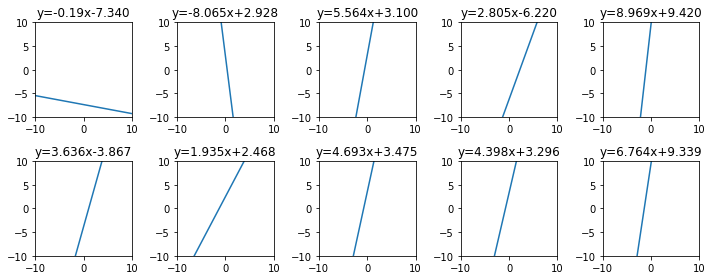

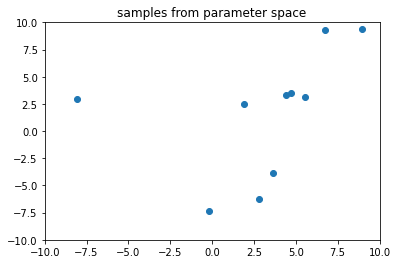

In [1]:
import numpy as np
import matplotlib.pyplot as plt

parameter_points = []
fig1, axes1 = plt.subplots(2, 5, figsize=(10, 4))

for ax in axes1.flatten():
    # np.random.uniform: 정해진 구간에서 수를 무작위로 추출하여 반환합니다.
    a, b = np.random.uniform(-10, 10, size=2)
    a = round(a, 3)
    b = round(b, 3)
    parameter_points.append((a, b))

    x = np.linspace(-10, 10, 50)
    y = a*x + b
    ax.plot(x, y)

    ax.set_title('y='+str(a)+'x'+'{0:+.03f}'.format(b))
    ax.set_xlim(-10, 10)
    ax.set_ylim(-10, 10)

plt.tight_layout()

px, py = np.split(np.array(parameter_points), 2, axis=1)
fig2 = plt.figure()
axes2 = plt.gca()

axes2.set_title('samples from parameter space')
axes2.set_xlim(-10, 10)
axes2.set_ylim(-10, 10)

plt.scatter(px, py)
plt.show()

아래 코드는 평균이 $(1,0)$이고 표준편차가 0.5인 정규분포에서 10개의 점을 무작위로 뽑은 다음, 대응되는 일차함수의 그래프를 각각 그려주는 코드입니다. 위쪽의 예제와 비교하면 파라미터 공간에서 추출된 샘플들이 $(1,0)$ 주위에 모여 있고, 결과 그래프들의 차이가 작은 것을 확인할 수 있습니다.

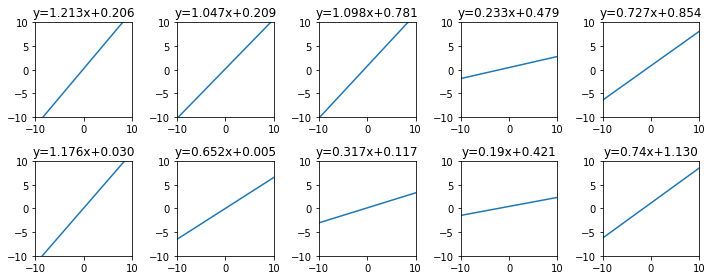

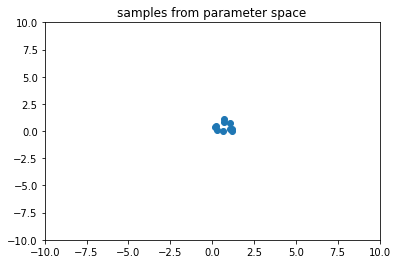

In [2]:
parameter_points = []
fig, axes1 = plt.subplots(2, 5, figsize=(10, 4))

for ax in axes1.flatten():
    # np.random.normal: 정규분포를 따르는 확률 변수의 랜덤한 값을 반환합니다.
    a, b = np.random.normal(loc=[1, 0], scale=0.5)
    a = round(a, 3)
    b = round(b, 3)
    parameter_points.append((a, b))

    x = np.linspace(-10, 10, 50)
    y = a*x + b
    ax.plot(x, y)

    ax.set_title('y='+str(a)+'x'+'{0:+.03f}'.format(b))
    ax.set_xlim(-10, 10)
    ax.set_ylim(-10, 10)

plt.tight_layout()

px, py = np.split(np.array(parameter_points), 2, axis=1)
fig2 = plt.figure()
axes2 = plt.gca()

axes2.set_title('samples from parameter space')
axes2.set_xlim(-10, 10)
axes2.set_ylim(-10, 10)

plt.scatter(px, py)
plt.show()

# posterior와 prior, likelihood 사이의 관계

베이지안 머신러닝 모델은 **데이터를 통해 파라미터 공간의 확률 분포를 학습**합니다.
모델 파라미터를 고정된 값이 아닌 **불확실성(uncertainty)을 가진 확률 변수**로 보는 것, 데이터를 관찰하면서 업데이트되는 값으로 보는 것은 **베이지안 머신러닝의 핵심 아이디어**입니다.

### posterior(사후확률), prior(사전확률), likelihood(가능도)

이제 데이터의 집합 

$X$가 주어졌습니다. 그러면 데이터가 따르는 어떤 확률 분포 
$p(X)$가 있겠죠.
우리의 목표는 
$p(X)$를 가장 잘 나타내는 일차함수 모델 $y=ax+b=θ^⊤x$를 찾는 것입니다.

<br>

데이터를 관찰하기 전 파라미터 공간에 주어진 확률 분포
$p(θ)$를 **prior(prior probability, 사전 확률)**이라고 합니다.

<br>

만약 prior 분포를 고정시킨다면, 주어진 파라미터 분포에 대해서 우리가 갖고 있는 **데이터가 얼마나 '그럴듯한지'** 계산할 수 있습니다. 이것을 나타내는 값이 **likelihood(가능도, 우도)**입니다. 식으로 나타내면, 
$p(X=x∣θ)$ 즉, 파라미터의 분포 
$p(θ)$가 정해졌을 때
$x$라는 데이터가 관찰될 확률이다.

likelihood가 높다는 것은 곧 우리가 지정한 파라미터 조건에서 데이터가 관찰될 확률이 높다는 것이고, 데이터의 분포를 모델이 잘 표현하는 것이라고 생각할 수 있다.
이렇게 데이터들의 likelihood 값을 최대화하는 방향으로 모델을 학습시키는 방법을 **최대 가능도 추정(maximum likelihood estimation, MLE)**이라고 한다.

<br>

반대로, 데이터 집합 $X$가 주어졌을 때 파라미터 $θ$의 분포 $p(θ∣X)$를 생각해볼 수 있습니다.
이 값을 '데이터를 관찰한 후 계산되는 확률'이라는 뜻에서 **posterior(posterior probability, 사후 확률)**라고 부릅니다.

posterior를 직접 계산해서 최적의 $θ$ 값을 찾는 것이 아니라, prior와 likelihood에 관한 식으로 변형한 다음, 그 식을 최대화하는 파라미터 $θ$를 찾습니다.
이렇게 posterior를 최대화하는 방향으로 모델을 학습시키는 방법을 **최대 사후 확률 추정(maximum a posteriori estimation, MAP)**이라고 합니다.

# likelihood와 머신러닝
머신러닝 모델은 어디까지나 한정된 파라미터로 데이터의 실제 분포를 근사하는 역할을 하기 때문에, 어떤 데이터가 들어와도 100%의 정확도를 내는 모델을 만들기는 불가능합니다. 그래서 모델이 입력 데이터로부터 예측한 출력 데이터(prediction)와 우리가 알고 있는 데이터의 실제 값(label) 사이에는 오차가 생기게 되는데, 우리에게 관찰되는 데이터에는 이미 **노이즈**가 섞여있어서 이런 오차가 발생한다고 해석합니다.

 값과 데이터의 라벨 $y_n$의 차이를 노이즈로 본다.

# likelihood 감 잡기

아래는 5개의 랜덤한 데이터 포인트를 생성하고 좌표평면 위에 표시해주는 코드입니다.

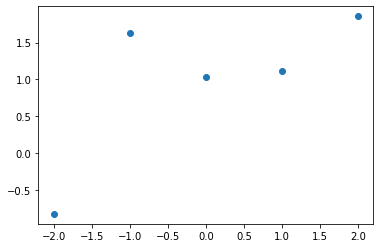

In [3]:
import math
import numpy as np
import matplotlib.pyplot as plt

np.random.seed(321)

input_data = np.linspace(-2, 2, 5)
label = input_data + 1 + np.random.normal(0, 1, size=5)

plt.scatter(input_data, label)
plt.show()

아래 코드에서 일차함수 모델의 식을 바꾸어가며 데이터 포인트 5개의 likelihood 값이 각각 어떻게 바뀌는지 살펴봅시다.
노이즈 분포의 표준편차는 데이터의 실제 분포와 관련된 값이라 우리가 알 수 없지만, 다음 스텝에서 공부할 MLE를 사용하면 표준편차를 알지 못해도 최적의 파라미터 값을 찾을 수 있습니다. 예제에서는 계산을 위해 표준편차를 0.1로 잡았습니다.

데이터 포인트 옆에 있는 숫자는 likelihood 값이고, 직선은 모델이 표현하는 함수의 그래프입니다.

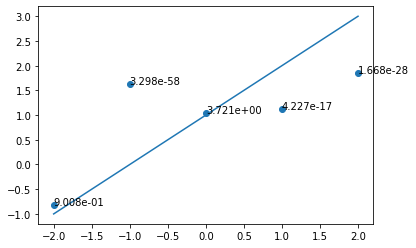

In [8]:
# model: y = ax + b
# a, b 값을 바꾸면서 실행해보세요
#-------------------------------#
a = 1
b = 1
#-------------------------------#

# 모델 예측값
model_output = a*input_data + b
likelihood = []

# x: 입력데이터, y: 데이터라벨
# 예측값과 라벨의 차이를 제곱해 exp에 사용
for x, y, output in zip(input_data, label, model_output):
    likelihood.append(1/(math.sqrt(2*math.pi*0.1*0.1))*math.exp(-pow(y-output,2)/(2*0.1*0.1)))

model_x = np.linspace(-2, 2, 50)
model_y = a*model_x + b

fig, ax = plt.subplots()
ax.scatter(input_data, label)
ax.plot(model_x, model_y)

for i, text in enumerate(likelihood):
    ax.annotate('%.3e'%text, (input_data[i], label[i]))

plt.show()

### likelihood가 왜 중요한가?
위 예제에서 보셨듯이, 데이터 포인트가 모델 함수에서 멀어질수록 데이터의 likelihood는 기하급수적으로 감소합니다. likelihood를 구하는 식을 보면 모델 예측값과 데이터 라벨의 차이를 제곱해서 exponential 위에 올려놓은 것을 확인할 수 있습니다. 예측값과 라벨의 차이가 조금만 벌어져도 likelihood 값은 민감하게 반응하겠죠.
머신러닝의 목표가 데이터 포인트들을 최대한 잘 표현하는 모델을 찾는 것이었다는 사실을 생각하면, 결국 데이터 포인트들의 likelihood 값을 크게 하는 모델을 찾는 것이 됩니다.

데이터의 likelihood 값을 최대화하는 모델 파라미터를 찾는 방법이 최대 가능도 추론(maximum likelihood estimation, MLE)입니다. 다음 스텝에서 MLE 방법론을 더 자세히 알아보고 코드를 통해 최적의 모델 파라미터를 계산해보도록 하겠습니다.